####  Importing required libraries

In [1]:
## Importing dataframe manipulation tools
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
%matplotlib inline

## Importing Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import BernoulliNB

## Step 1 - Preprocessing economic data

In [2]:
## Reading economic data - data acquired from one of the projects form kaggle.com
calendar11_13 = pd.read_excel("D2011-13.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
calendar14_18 = pd.read_excel("D2014-18.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
calendar19_20 = pd.read_excel("D2019-20.xls", header = None, index_col = 0, parse_dates = True, na_values = "0")
economic_calendar = calendar11_13.append(calendar14_18.append((calendar19_20)))
col_name = ['Time', 'Country','Volatility','Event_desc','Event_eval',
            'Data_format','Actual','Forecast','Previous']
economic_calendar.columns = col_name
economic_calendar.index.names = ['Date']
economic_calendar = economic_calendar.fillna(0)

## Remove white spaces from columns
economic_calendar['Country']=(economic_calendar['Country'].str.strip())
economic_calendar['Volatility']=(economic_calendar['Volatility'].str.strip())
economic_calendar['Event_desc']=(economic_calendar['Event_desc'].str.strip())
economic_calendar['Event_eval']=(economic_calendar['Event_eval'].str.strip())

## Filtering US Data
US_data = economic_calendar[economic_calendar['Country']=="United States"]
US_data.head()

,Time,Country,Volatility,Event_desc,Event_eval,Data_format,Actual,Forecast,Previous
Date,,,,,,,,,
2011-01-01,04:00:00,United States,Moderate Volatility Expected,10-Year Note Auction,NaN,%,3.38,,2.63
2011-01-01,04:00:00,United States,Low Volatility Expected,3-Month Bill Auction,NaN,%,0.18,,0.18
2011-01-01,04:00:00,United States,Low Volatility Expected,3-Year Note Auction,NaN,%,0.73,,0.5
2011-01-01,04:00:00,United States,Low Volatility Expected,30-Year Bond Auction,NaN,%,4.25,,4.25
2011-01-01,04:00:00,United States,Low Volatility Expected,5-Year Note Auction,NaN,%,2.13,,1.38


For the purpose of this exercise - I will only be using four economic indicators; <b>oil invetory</b>, <b>industrial production index</b>, <b>manufacturing production index</b> and <b>crude oil speculative position</b>. This is because these factors would allow us gain a hollistic view on the economy and where it is headed. 

<b><u>Note<u></b>: In reality, one might look into different factors to guage where the economy is headed such as interest rate, BOP, BOT etc.

In [3]:
## Extracting data on the four economic indicators 
oil_inventory = [c for c in US_data["Event_desc"] if 'Crude Oil Inventories' in c]
industrial_production = [c for c in US_data["Event_desc"] if "Industrial Production" in c]
manufacturing_production = [c for c in US_data["Event_desc"] if "Manufacturing Production" in c]
crude_oil_speculative_positions = [c for c in US_data["Event_desc"] if 'CFTC Crude Oil speculative net positions' in c]

## Extracting data sets on each indicator
oil_inventory = US_data[US_data["Event_desc"].isin(oil_inventory)]
industrial_production = US_data[US_data["Event_desc"].isin(industrial_production)]
manufacturing_production = US_data[US_data["Event_desc"].isin(manufacturing_production)]
crude_oil_speculative_positions = US_data[US_data["Event_desc"].isin(crude_oil_speculative_positions)]

In [4]:
## Helper functions to convert data in string format into float for calculation purposes
def adjust_data(positions):
    ## takes in a string and returns a float * 1000 
    positions = str(positions).strip()
    if 'k' in str(positions):
        positions = str(positions)[:-1]
        return float(positions) * 1000
    return float(positions) * 1000

## Setting up crude oil column    
crude_oil_speculative_positions['Adjusted_Actual'] = crude_oil_speculative_positions.Actual.apply(adjust_data)

<ipython-input-4-ddd1e018de35>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crude_oil_speculative_positions['Adjusted_Actual'] = crude_oil_speculative_positions.Actual.apply(adjust_data)


Because the frequency of data is not the same, I decided to resample data on monthly basis to make the dataset balanced. Here, one could use different oversampling methods to make the dataset more balanced. 

In [5]:
## Preparing Oil Inventory data
oil_inventory = (pd.to_numeric(oil_inventory["Actual"]).to_frame()).resample("M").sum()
oil_inventory['Datetime'] = (oil_inventory.index.strftime("%m-%y"))
oil_inventory.set_index('Datetime', inplace = True)
## Preparing Industrial Production data
industrial_production = (pd.to_numeric(industrial_production["Actual"]).to_frame()).resample("M").sum()
industrial_production['Datetime'] = (industrial_production.index.strftime("%m-%y"))
industrial_production.set_index('Datetime', inplace = True)
## Preparing Manfucturing Production data
manufacturing_production = (pd.to_numeric(manufacturing_production["Actual"]).to_frame()).resample("M").sum()
manufacturing_production['Datetime'] = (manufacturing_production.index.strftime("%m-%y"))
manufacturing_production.set_index('Datetime', inplace = True)
## Preparing Crude Oil Speculative Positions data
crude_oil_speculative_positions = (crude_oil_speculative_positions[['Adjusted_Actual']]).resample("M").sum()
crude_oil_speculative_positions['Datetime'] = (crude_oil_speculative_positions.index.strftime("%m-%y"))
crude_oil_speculative_positions.set_index('Datetime', inplace = True)

Once all the individual data sets are pre-processed, the next step is to combine all of them into one dataframe. This is done in the next cell.

In [6]:
model_data = pd.merge(oil_inventory,crude_oil_speculative_positions,on = "Datetime",how = 'outer')
model_data = pd.merge(model_data,manufacturing_production,on = "Datetime",how = 'outer')
model_data = pd.merge(model_data,industrial_production,on = "Datetime",how = 'outer')
model_data.columns = ['crude_oil_inventory','crude_oil_spec_position','manufacturing_index','industrial_index']
model_data.dropna(inplace = True)
model_data.head()

,crude_oil_inventory,crude_oil_spec_position,manufacturing_index,industrial_index
Datetime,,,,
01-11,1.0,628500.0,0.4,0.8
02-11,6.2,702700.0,0.2,-0.1
03-11,8.8,1055800.0,0.0,-0.1
04-11,7.5,1262500.0,0.7,0.8
05-11,7.8,858100.0,-0.6,0.0


## Step 2 - Getting Asset Data

Now that we have preprocessed the economic data required for the model the next step is to get the monthly price data for any asset class and use the adjusted close column for our algorithms. For this exercise I am using <b>Exxon Mobil stock (XOM) </b>.

Since we are working with time series data, we would have normally used ARIMA or EWMA models. For this exercise - I will be manually handling lag by adding <b>t+1</b> asset price to economic data that relates to time <b>t</b>. In practice, it may not the best approach. 

In [7]:
import yfinance as yf
# Company Ticker
# symbol = "GC=F"
symbol = 'XOM'
# 'IYT'

#Import asset price data from yahoo finance
Asset_data = yf.download(symbol,start = "2010-01-01",end="2020-04-30", progress=True, interval='1mo')
Asset_data['Datetime'] = (Asset_data.index.strftime("%m-%y"))
Asset_data.set_index('Datetime', inplace = True)
Asset_data = (Asset_data[['Adj Close']].rename(columns={'Adj Close':"Adj_Close"}))
## Merge company data with 
final_data = (pd.merge(Asset_data,model_data,on = "Datetime",how = 'inner')).dropna()
final_data.head()

[*********************100%***********************]  1 of 1 completed


,Adj_Close,crude_oil_inventory,crude_oil_spec_position,manufacturing_index,industrial_index
Datetime,,,,,
01-11,55.539688,1.0,628500.0,0.4,0.8
02-11,58.878391,6.2,702700.0,0.2,-0.1
03-11,58.219833,8.8,1055800.0,0.0,-0.1
04-11,60.884159,7.5,1262500.0,0.7,0.8
05-11,57.763115,7.8,858100.0,-0.6,0.0


In [8]:
## Since I am treating the problem as a classification problem therefore I am interested in calculating
## if the asset price moved up or down
final_data['movement'] = final_data.Adj_Close - final_data.Adj_Close.shift(1)


## function to classify upward movement as 1, downward as -1 and if its the same then 0
def categorize_movement(value):
    if value > 0: 
        return 1
    if value < 0:
        return -1
    return 0 
final_data['movement_category'] = final_data.movement.apply(categorize_movement)
final_data.dropna(inplace=True)
final_data.head()

,Adj_Close,crude_oil_inventory,crude_oil_spec_position,manufacturing_index,industrial_index,movement,movement_category
Datetime,,,,,,,
02-11,58.878391,6.2,702700.0,0.2,-0.1,3.338703,1
03-11,58.219833,8.8,1055800.0,0.0,-0.1,-0.658558,-1
04-11,60.884159,7.5,1262500.0,0.7,0.8,2.664326,1
05-11,57.763115,7.8,858100.0,-0.6,0.0,-3.121044,-1
06-11,56.636185,-11.4,682700.0,0.2,0.1,-1.126930,-1


## Step 3 - Split the data for Algorithms

Splitting 70% of for training purposes and using 30% for testing and back testing. 
Note that while one could use multiple classification models here and use what the majority of models predict as proxy for trading siganl, I only used the Bernoulli Naive Bayes Classifier. This is because it works well with a smaller data set. If I had access to more data points then using different algorithms would make the prediction alot more better.

In [24]:
X = final_data[['crude_oil_inventory', 'crude_oil_spec_position',
       'manufacturing_index', 'industrial_index']]
y = final_data['movement_category']

X_train = X[:int(X.shape[0]*0.7)]
X_test = X[int(X.shape[0]*0.7):]
y_train = y[:int(X.shape[0]*0.7)]
y_test = y[int(X.shape[0]*0.7):]

In [25]:
backtest_df = pd.DataFrame()
tscv = TimeSeriesSplit(n_splits=3)
for tr_index, val_index in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_index], X_train.iloc[val_index]
    y_tr, y_val = y_train.iloc[tr_index], y_train.iloc[val_index]
    
    models = [
#           ('LogReg', LogisticRegression()), 
#           ('RF', RandomForestClassifier()),
#           ('KNN', KNeighborsClassifier()),
#           ('SVM', SVC()), 
          ('BERN', BernoulliNB()),
#           ('GNB', GaussianNB()),  
#           ('XGB', XGBClassifier())
        ]
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        backtest_df[name] = y_pred

Text(0.5, 1.0, 'Comparing Machine Learning Strategy performance with Buy-and-Hold')

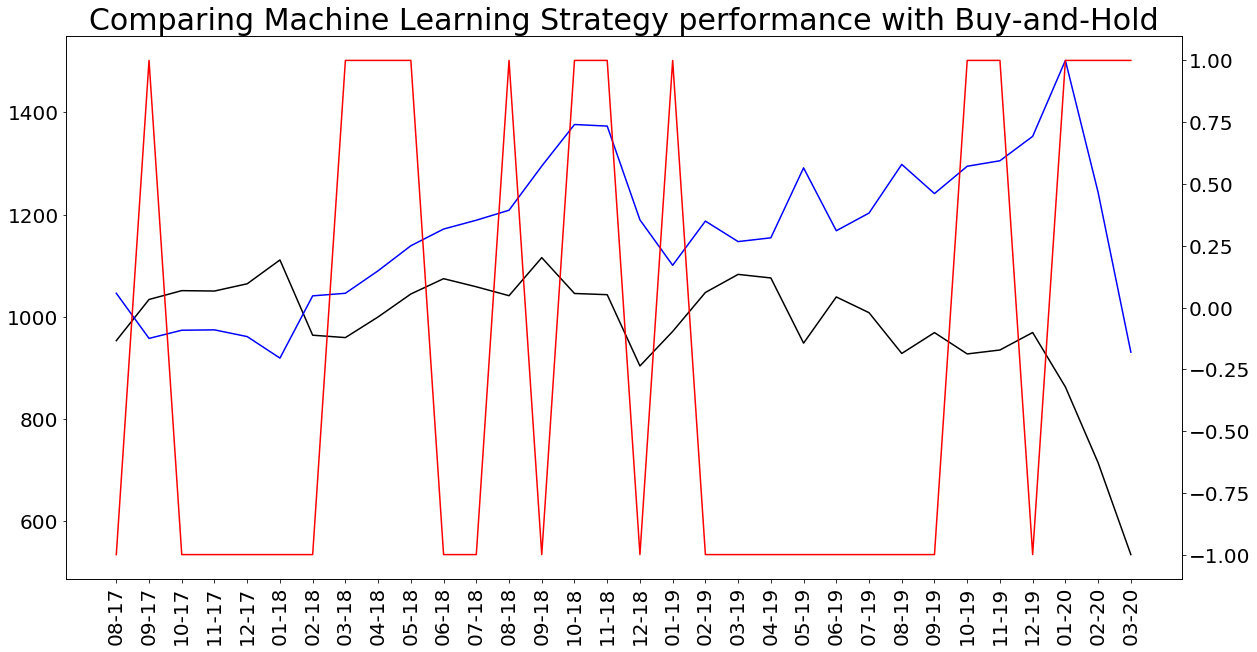

In [26]:

price_data = (final_data[int(X.shape[0]*0.7):].Adj_Close).to_frame()
price_data.reset_index(inplace=True)


backtest_df['signal']=backtest_df.mode(axis=1)
backtest_df['price'] = price_data['Adj_Close'].to_numpy()
backtest_df['position'] = (backtest_df['signal'])*1
backtest_df.dropna(inplace=True)



#Compute returns
lag_prc = backtest_df['price'].shift(1) #Previous-day price
backtest_df['Ret_Stock'] = (backtest_df['price'] - lag_prc)/lag_prc #compute daily return
backtest_df['Ret_Strat'] = backtest_df["position"].shift(1) * backtest_df['Ret_Stock'] #Use previous-day position
backtest_df.index = y_test.index
#Compute $1000 invested in the two strategies
backtest_df.dropna(inplace=True)
initVal = 1000
cumValue_BHS = initVal*(1+backtest_df['Ret_Stock']).cumprod() #compute cumulative compounded returns of buy-and-hold strategy
cumValue_ML = initVal*(1+backtest_df['Ret_Strat']).cumprod() #compute cumulative compounded returns of SMAS strategy

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(backtest_df.index, cumValue_BHS,color='black')
plt.plot(backtest_df.index, cumValue_ML,color='blue')
ax.xaxis.set_tick_params(rotation=90, labelsize=20)
ax.yaxis.set_tick_params(rotation=0, labelsize=20)

ax2 = ax.twinx()
ax2.plot(backtest_df.index,backtest_df['position'],color='red')
ax2.yaxis.set_tick_params(rotation=0, labelsize=20)

plt.title("Comparing Machine Learning Strategy performance with Buy-and-Hold",fontsize = 30)


Notice that the ML strategy performed better than Buy-and-hold strategy for the most part of the investment period. However, starting February 2020 both the strategies incurred extreme losses. This coincides with Covid-19 and can be explained that due to the pandemic econmic activity slowed down. This inturn reduced demand for oil and therefore, adding a downward pressure on oil prices or stock prices of companies in the oil and gas sector. 

## Step 4 - Evaluating Performance

Since we have implmented the algorithm we can evaluate the performance of the two strategy. The results can be seen below

In [27]:

avg_return = backtest_df[["Ret_Stock","Ret_Strat"]].mean()
volatility = backtest_df[["Ret_Stock","Ret_Strat"]].std()
#Annualized measures
annual_return = avg_return * 12
annual_vol = volatility * np.sqrt(12)
SR = annual_return/annual_vol #We assume for simplicity that the risk-free rate is zero, so excess returns equal raw returns
print("Investing $1000 in the buy-and-hold strategy produces $%5.1f over the investment period"%(cumValue_BHS.tail(1)))
print("Investing $1000 in the ML Strategy strategy produces $%5.1f over the investment period"%(cumValue_ML.iloc[-1]))
# The instruction 'cumValue_SMAS.iloc[-1]' is equivalent to 'cumValue_SMAS.tail(1)
print("The annual arithmetic average return for BHS is %5.2f%% with a volatility of %5.2f%%"\
      %(annual_return[0]*100,annual_vol[0]*100))
print("The annual arithmetic average return for ML Strategy is %5.2f%% with a volatility of %5.2f%%"\
      %(annual_return[1]*100,annual_vol[1]*100))
print("The annualized Sharpe Ratio for the buy-and-hold strategy is %4.2f, for ML Strategy is %4.2f" %(SR[0],SR[1]))

Investing $1000 in the buy-and-hold strategy produces $535.1 over the investment period
Investing $1000 in the ML Strategy strategy produces $931.1 over the investment period
The annual arithmetic average return for BHS is -19.03% with a volatility of 28.25%
The annual arithmetic average return for ML Strategy is  1.64% with a volatility of 28.80%
The annualized Sharpe Ratio for the buy-and-hold strategy is -0.67, for ML Strategy is 0.06


If you have any feedback or comments, feel free to reach out at soom6820@mylaurier.ca. 
Thank you!